### Example code for computing CIV distance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import richardsplot as rplot
from sklearn.preprocessing import scale

from CIVfunctions import project, CIV_distance

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


---

#### Basic implementation

Load in example file with CIV EW+Blueshift already computed.

In [2]:
dat = pd.read_csv("data/LOFAR_from8403colorselected_all388_CIV.csv")
dat.iloc[:,10:].head()

,SDSS_NAME_1a,RA_1a,DEC_1a,REDSHIFT,PLATE_1a,FIBER_1a,MJD_1a,TARGET_FLAG_TARGET,NSPECOBS,UNIFORM_TARGET,...,Separation_2,CIV_blue,CIV_EW,good,z_paul,SDSS_NAME_2,Separation_Amy,CIV_DIST_021721,Separation,CIV_DIST_041921
0,104446.00+521742.8,161.191681,52.295242,1.7513,1010,182,52649,3,1,1,...,0.015827,87.889379,37.666121,True,1.75054,104446.00+521742.8,0.015827,2.522933,0.002494,2.124091
1,104547.58+551853.8,161.448257,55.314972,1.8896,906,462,52368,1048578,1,1,...,0.008950,142.521789,44.743671,True,1.88758,104547.58+551853.8,0.008950,2.422896,0.003449,1.985659
2,104718.64+541917.8,161.827698,54.321629,1.8288,906,55,52368,3145739,1,1,...,0.013102,832.307354,49.698713,True,1.83249,104718.64+541917.8,0.013102,2.791469,0.005172,2.129244
3,104829.97+550819.0,162.124893,55.138630,2.0671,906,518,52368,1048578,1,1,...,0.012861,1798.550056,22.573777,True,2.07342,104829.97+550819.0,0.012861,3.848747,0.003931,3.199583
4,104852.00+530747.2,162.216675,53.129780,1.6792,1010,509,52649,1048578,1,1,...,0.007413,872.211364,51.004578,True,1.68111,104852.00+530747.2,0.007413,2.801772,0.002967,2.110882


In [3]:
ew   = dat[["CIV_EW"]].values.flatten()
blue = dat[["CIV_blue"]].values.flatten()

#Best-fit line -- this part could be improved
bestfit = np.load("data/RM_CIV_bestFitLine_noScale.npy")[65000:,:]

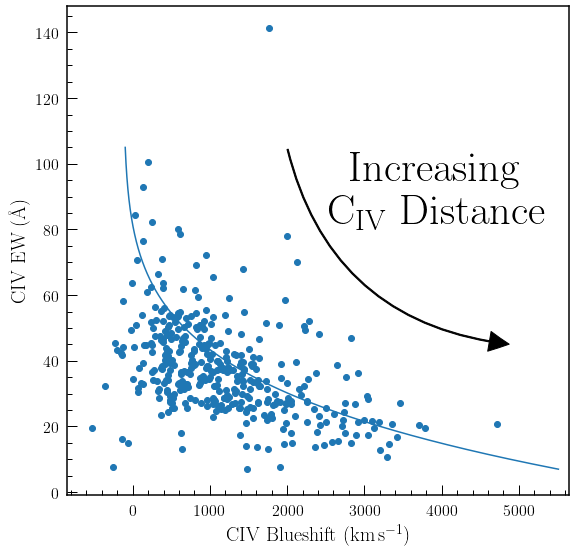

In [4]:
fig = plt.figure(figsize=(9,9))

#Visualize increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((2000, 105), (4900, 45),
                             connectionstyle="arc3,rad=.35", **kw)
plt.gca().add_patch(a1)
plt.text(x=2800,y=95,s="Increasing", fontsize=42.5, weight='extra bold')
plt.text(x=2535,y=82,s="C$_\mathrm{IV}$ Distance", fontsize=42.5)

plt.plot(bestfit[:,0], bestfit[:,1])
plt.scatter(blue, ew)
plt.xlabel("CIV Blueshift (km\,s$^{-1}$)", fontsize=20)
plt.ylabel("CIV EW (Å)", fontsize=20)
plt.xlim(-850,5650)
plt.ylim(-1,148)

plt.show()

Note: points with EW $\gtrsim105$ Angstroms will be projected onto the top of the curve.

In [5]:
from time import time

start = time()
data = np.array([blue, ew]).T
dist = CIV_distance(data, bestfit) #compute CIV distances like this
end = time()

---

#### Save time with the ``step`` parameter

``CIV_distance()`` function has an optional "step" parameter.  How it's normally set up is to project each data point onto the best-fit curve, then travel along the best-fit line--point-by-point--checking when you've passed a point on the line.  The default argument ``step=1`` will check every point along the curve, ``step=100`` will check every hundredth point etc.  Since the curve is so dense, you can often get away with a much higher step size than 1, decreasing your runtime dramatically (especially on bigger datasets); for example, ``step=100`` will result in 100 times less iterations of the for loop inside ``CIV_distance()``.

Visualize accuracy as a function of step size.  Will consider "correct" to be the distances corresponding to ``step=1``.

In [6]:
from functools import reduce

#Get all factors of input number- use this function to find valid step sizes
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [7]:
step_list = np.sort(list(factors(98000)))[0:-15:2]
diff_list = [0]
dt_list   = [end - start]

In [8]:
step_list

array([   1,    4,    7,   10,   16,   25,   35,   49,   56,   80,  100,
        125,  175,  200,  250,  350,  400,  500,  700,  875, 1000, 1400,
       1960])

In [9]:
for step_size in step_list[1:]:
    start_time = time()
    idist = CIV_distance(data, bestfit, step=step_size)
    diff_list.append(np.median(np.abs((dist-idist)/dist)))
    end_time = time()
    dt_list.append(end_time - start_time)

In [10]:
plt.subplots?

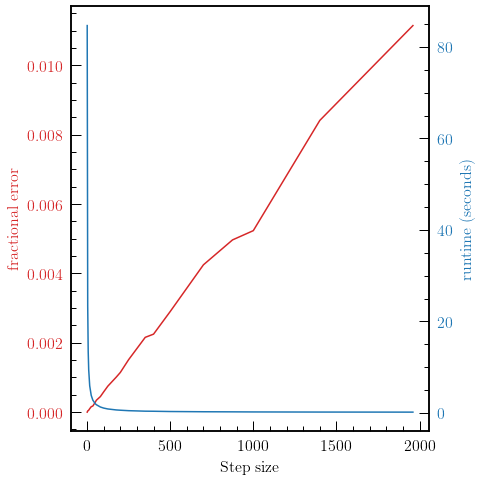

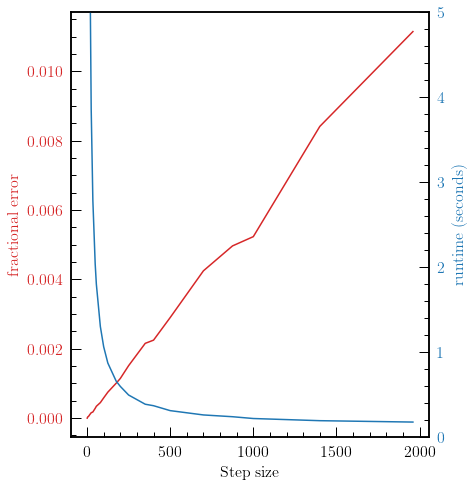

In [11]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Step size')
ax1.set_ylabel('fractional error', color=color)
ax1.plot(step_list, diff_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('runtime (seconds)', color=color)  # we already handled the x-label with ax1
ax2.plot(step_list, dt_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

fig, ax11 = plt.subplots()

color = 'tab:red'
ax11.set_xlabel('Step size')
ax11.set_ylabel('fractional error', color=color)
ax11.plot(step_list, diff_list, color=color)
ax11.tick_params(axis='y', labelcolor=color)

ax22 = ax11.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax22.set_ylabel('runtime (seconds)', color=color)  # we already handled the x-label with ax1
ax22.plot(step_list, dt_list, color=color)
ax22.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax22.set_ylim(0,5)
plt.show()

Plot showing both the time saved and median error in C IV distance as a function of step size.  Lesson learned: use a non-unity step size for lots of data! Roughly ``step=200`` looks like a good choice.  **Use the step parameter when testing big datasets.**